# Symbols classification

This example demonstrates how to construct a neural network capable of classifying symbols. 

In [44]:
import os
import http
import tqdm
import tarfile
from random import randint
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim.sgd import SGD
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

MY_FILES_PATH = Path("symbols_classification_files")
SEED = 10

## Data

Let's load and examine the data we'll use to train our model.

### Loading and unpacking

The follwing code loads data and unpacks them.

In [2]:
target_file_path = MY_FILES_PATH/"notMNIST_small.tar.gz"
data_folder_path = MY_FILES_PATH/"notMNIST_small"

if not target_file_path.exists():
    conn = http.client.HTTPConnection("yaroslavvb.com", 80)
    conn.request("GET", "/upload/notMNIST/notMNIST_small.tar.gz")
    data = conn.getresponse().read()
    with open(target_file_path, "wb") as f:
        f.write(data)

if not data_folder_path.exists():
    with tarfile.open(target_file_path) as f:
        f.extractall(str(MY_FILES_PATH))

We got a batch of folders each represent some class.

In [3]:
os.listdir(data_folder_path)

['I', 'G', 'B', 'J', 'C', 'H', 'F', 'E', 'D', 'A']

Each folder contains numerous images, for corresponding symbol. 

In [4]:
os.listdir(data_folder_path/"C")[:5]

['Q2FuYWRpYW5QaG90b2dyYXBoZXIub3Rm.png',
 'RkZGIEludGVyZmFjZTAxYi50dGY=.png',
 'QmFzZU1vbm9XaWRlVGhpbiBSZWd1bGFyLnR0Zg==.png',
 'R2luZ2VyLVJlZ3VsYXJJdGFsaWNFeHBlcnQub3Rm.png',
 'QmVsbENlbnRlbm5pYWwtTmFtZUFuZE51bWJlci5vdGY=.png']

### Interpret as tensors

Now that we have images, we need to interpret them as tensors - the following code loads them as `np.ndarrays`.

In [21]:
images, labels = [], []
for img_path in data_folder_path.glob("**/*.png"):
    # Foleder name is a class label
    img_label = img_path.parts[-2]
    try:
        image = plt.imread(img_path)
    except SyntaxError:
        print(f"Loading error for {img_path}")
        continue
    labels.append(img_label)
    images.append(image)


# `torch.Tensor` doesn't support strings as elements of the tensor, we save 
# values as `numpy.array`
y_labels = np.stack(labels, axis=0)
X, y = (
    torch.tensor(np.stack(images, axis=0)), 
    torch.tensor(LabelEncoder().fit_transform(y_labels))
)


X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, shuffle=True, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, shuffle=True, random_state=SEED
)

Loading error for symbols_classification_files/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png
Loading error for symbols_classification_files/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png


We have successfully created an `X` tensor containing 18,724 images, each with a size of 28x28 pixels.  Alongside this, we have a `y` tensor holding 18,724 corresponding labels. 

In [22]:
X.shape, y.shape

(torch.Size([18724, 28, 28]), torch.Size([18724]))

To verify the data has loaded correctly, let's randomly sample images and display their titles alongside their corresponding labels. 

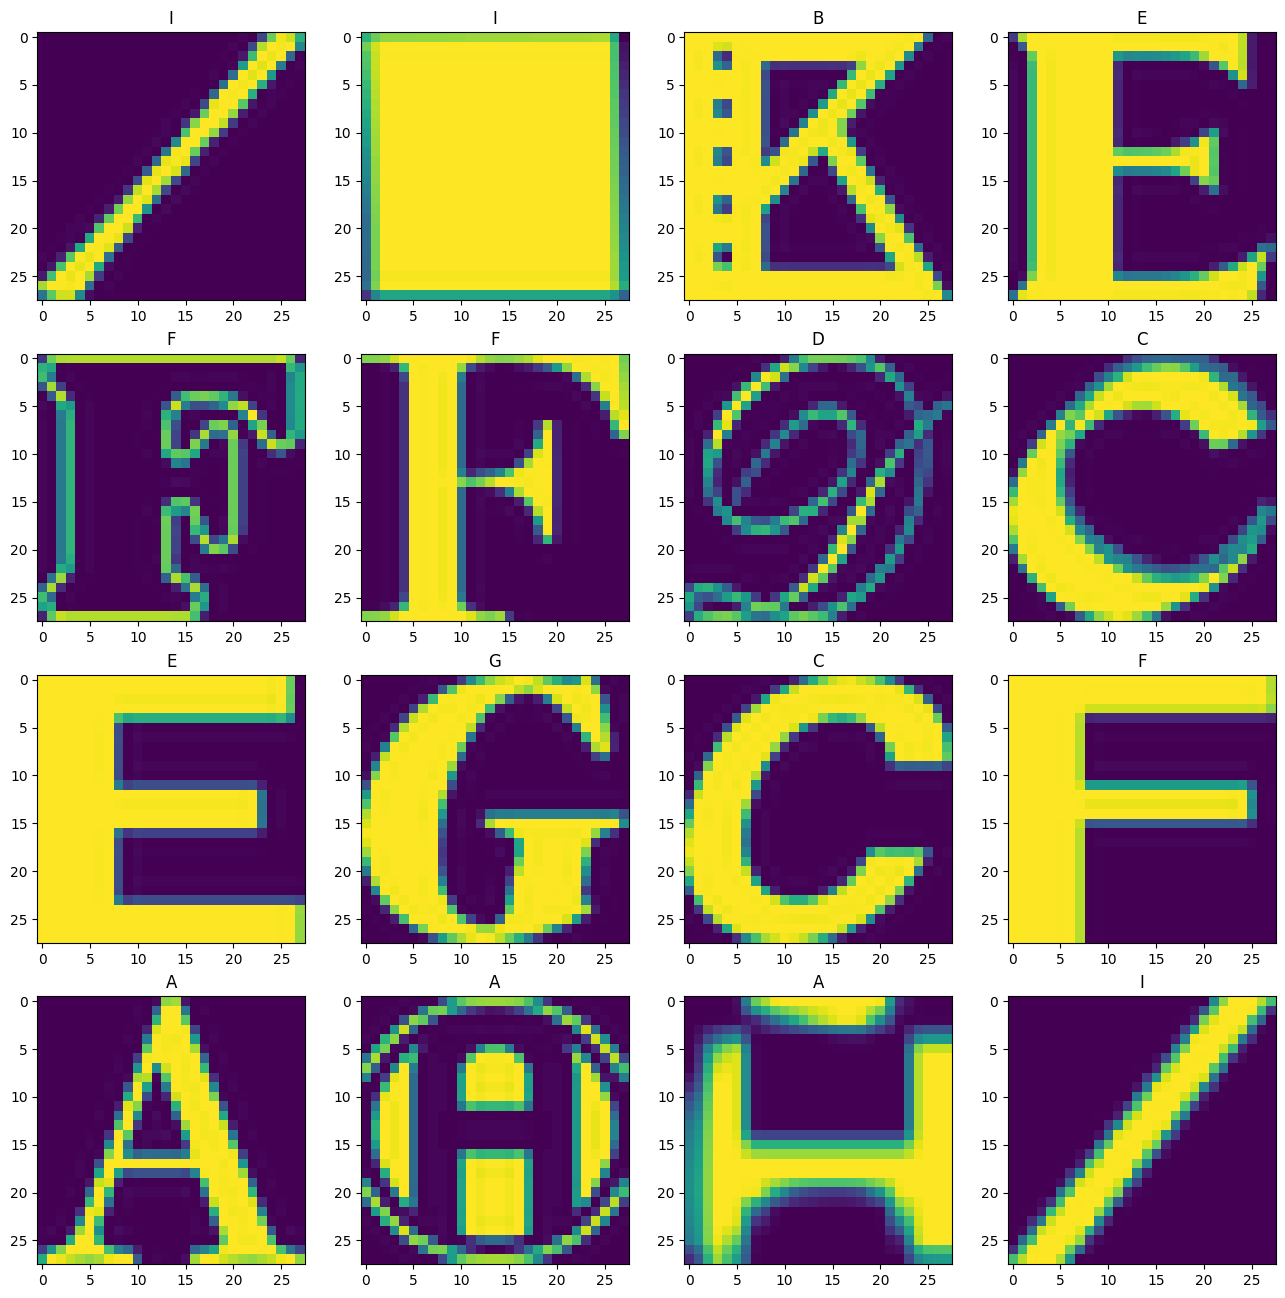

In [23]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for row in range(4):
    for col in range(4):
        idx = 4 * row + col
        idnex = randint(0, len(X))
        ax[row][col].imshow(X[idnex])
        ax[row][col].set_title(f"{y_labels[idnex]}")

## Model form

As an example, we will use two fully connected layers with ReLU activations. The following cell defines net that we'll use.

In [30]:
class ReLUFullyConnected(nn.Module):

    def __init__(self, num_classes: int):
        super().__init__()

        hidden_dim = 16**2
        linear_1 = nn.Linear(in_features=28**2, out_features=hidden_dim)

        act_1 = nn.ReLU()

        linear_2 = nn.Linear(
              in_features=hidden_dim, 
              out_features=num_classes
        )

        act_2 = nn.Softmax(dim=1)

        self.procedure = nn.Sequential(
            linear_1, act_1, linear_2, act_2
        )

    def forward(self, x: torch.Tensor):
        x = x.reshape((-1, 28 * 28))
        x = self.procedure(x)
        return x

Let's check if implemented model operates with inputs we supposed it to operate with.

In [55]:
model = ReLUFullyConnected(len(np.unique(y)))
model(X[:5])

tensor([[0.1081, 0.1029, 0.0849, 0.0798, 0.0723, 0.1102, 0.1026, 0.0676, 0.1276,
         0.1439],
        [0.1253, 0.0749, 0.0797, 0.0486, 0.0725, 0.1018, 0.1209, 0.0578, 0.1182,
         0.2003],
        [0.1130, 0.0926, 0.0909, 0.0865, 0.0696, 0.1087, 0.1098, 0.0773, 0.1172,
         0.1344],
        [0.1244, 0.0872, 0.0973, 0.0767, 0.0888, 0.1047, 0.0948, 0.0819, 0.1105,
         0.1336],
        [0.1253, 0.0749, 0.0797, 0.0486, 0.0725, 0.1018, 0.1209, 0.0578, 0.1182,
         0.2003]], grad_fn=<SoftmaxBackward0>)

By feeding the model 5 observations, we received 5 sets of 10 numbers, which we'll interpret as the probability of each corresponding class. 

## Fitting

The model fitting procedure is as follows: 

In [45]:
optimizer = SGD(
    params=model.parameters(),
    lr=1e-1
)
losses = []


for _ in tqdm.trange(2_000):
    optimizer.zero_grad()

    output = model(X_train)
    loss = F.cross_entropy(output, y_train)
    loss.backward()

    optimizer.step()

    losses.append(loss.detach().item())

100%|██████████| 2000/2000 [03:44<00:00,  8.93it/s]


Model's learning curve.

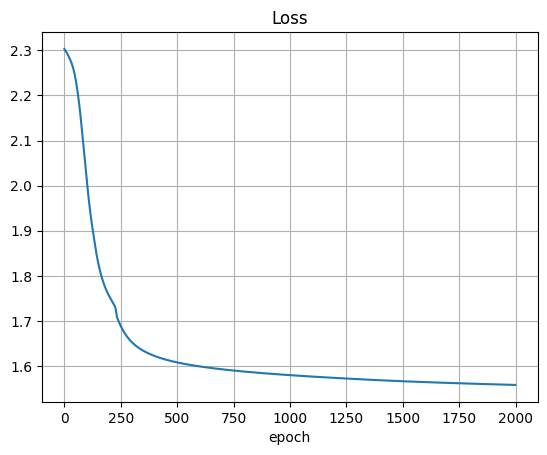

In [48]:
plt.plot(losses)
plt.title("Loss")
plt.xlabel("epoch")
plt.grid()
plt.show()

Finally, we will assess the model's accuracy. 

In [52]:
def accuracy(
    model: torch.nn.Module, 
    x: torch.Tensor, 
    y: torch.Tensor
):
    return torch.sum(torch.argmax(model(x), dim=1) == y) / len(y)


print(f"train accuracy: {accuracy(model, X_train, y_train)}")
print(f"val accuracy: {accuracy(model, X_val, y_val)}")
print(f"test accuracy: {accuracy(model, X_test, y_test)}")

train accuracy: 0.9157804846763611
val accuracy: 0.8846482634544373
test accuracy: 0.8940397500991821
